### Link to the dataset

https://www.kaggle.com/datasets/heeraldedhia/us-economic-news-articles

In [16]:
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split

# pre-processing of text
import re
import string

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

In [2]:
df = pd.read_csv('US-Economic-News.csv',encoding="ISO-8859-1")
df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
7935,830985572,False,finalized,3,11/17/15 20:53,NaN,NaN,no,0.6812,wapo_307530763,4/12/92,Mutual Funds Flat in Quarter; Lackluster Showi...,NaN,NaN,"Trapped in a moody, directionless market, mutu..."
7429,830985065,False,finalized,3,11/18/15 11:31,NaN,NaN,no,1.0000,wapo_307244332,12/16/89,Virginia Braces for Shortfall;Pension Tax Reli...,NaN,NaN,A slowdown in Virginia's economy could create ...
3641,842617105,False,finalized,3,12/5/15 4:45,2.0,0.3534,yes,1.0000,wsj_399051597,6/11/09,Rate Rise Clouds Recovery,NaN,NaN,Rising interest rates threaten to dim prospect...
472,842613930,False,finalized,3,12/5/15 21:26,NaN,NaN,no,1.0000,wsj_398961587,2/19/02,"Ciena Is Moving to Acquire ONI, Creating a Gia...",NaN,NaN,"LINTHICUM, Md. -- Ciena Corp. agreed to acquir..."
4901,830982531,False,finalized,3,11/18/15 2:56,NaN,NaN,no,1.0000,wapo_147318810,7/16/81,"die tottsljington Thursday, July 16, 1981",NaN,NaN,"NEW YORK, July 15 ÛÓ With an ease that seems ..."


In [3]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance',
       'relevance:confidence', 'articleid', 'date', 'headline',
       'positivity_gold', 'relevance_gold', 'text'],
      dtype='object')

In [4]:
_stop_words.ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [5]:
temp = {"text":df['text'],"relevance":df['relevance']}
our_data = pd.DataFrame(temp)
our_data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,yes
1,The Wall Street Journal Online</br></br>The Mo...,no
2,WASHINGTON -- In an effort to achieve banking ...,no
3,The statistics on the enormous costs of employ...,no
4,NEW YORK -- Indecision marked the dollar's ton...,yes
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,yes
7996,"U.S. stocks inched up last week, overcoming co...",no
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,no
7998,The White House's push to contract out many fe...,no


In [6]:
df.relevance.value_counts()
# imbalanced dataset

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

##  The dataset is imbalanced

In [8]:
our_data.text[1]

'The Wall Street Journal Online</br></br>The Morning Brief, a look at the day\'s biggest news, is emailed to subscribers by 7 a.m. every business day. Sign up for the e-mail here.</br></br>On Friday evening, with Congress out of town on its summer recess and Americans heading into a mid-August weekend, the Bush administration sent a message to the states: The federal government will make it tougher for a national children\'s insurance program to cover the offspring of middle-income families.</br></br>The State Children\'s Health Insurance Program was created in 1997 to help children whose families couldn\'t afford insurance but didn\'t qualify for Medicaid, and administration officials tell the New York Times that the changes are aimed at returning the program to its low- income focus and assuring it didn\'t become a replacement for private insurance. Administration point man Dennis Smith wrote to state officials saying there would be new restrictions on the District of Columbia and th

## The data needs to be preprocessed 

In [2]:
# remove <br> tags
# remove punctuation
# lowercase everything


In [17]:
def clean(doc):
    doc = doc.lower()
    punctuation_pattern = re.compile(f"[{re.escape(string.punctuation)}]+")
    doc = punctuation_pattern.sub("", doc)
    doc = doc.replace("<br>","")
    return doc

In [18]:
clean(our_data.text[1])

'the wall street journal onlinebrbrthe morning brief a look at the days biggest news is emailed to subscribers by 7 am every business day sign up for the email herebrbron friday evening with congress out of town on its summer recess and americans heading into a midaugust weekend the bush administration sent a message to the states the federal government will make it tougher for a national childrens insurance program to cover the offspring of middleincome familiesbrbrthe state childrens health insurance program was created in 1997 to help children whose families couldnt afford insurance but didnt qualify for medicaid and administration officials tell the new york times that the changes are aimed at returning the program to its low income focus and assuring it didnt become a replacement for private insurance administration point man dennis smith wrote to state officials saying there would be new restrictions on the district of columbia and the 18 states  including california and new york

In [19]:
X = []
for i in range(len(our_data.text)):
    X.append(clean(our_data.text[i]))   

In [20]:
X = pd.DataFrame(X)
X

,0
0,new york yields on most certificates of depos...
1,the wall street journal onlinebrbrthe morning ...
2,washington in an effort to achieve banking re...
3,the statistics on the enormous costs of employ...
4,new york indecision marked the dollars tone a...
...,...
7995,secretary of commerce charles w sawyer said ye...
7996,us stocks inched up last week overcoming conce...
7997,ben s bernanke cleared a key hurdle thursday t...
7998,the white houses push to contract out many fed...


##  Solving the dataset imbalance problem using imblearn's RandomOverSampler

In [21]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
new_df = ros.fit_resample(X,df['relevance'])



In [22]:
len(new_df[0])

19713

In [23]:
type(new_df[0])

pandas.core.frame.DataFrame

In [24]:
X1 = new_df[0]
X1.rename(columns={0:"text"},inplace=True)


In [25]:
X1['relevance'] = new_df[1]


In [26]:
X1.relevance.value_counts()

yes         6571
no          6571
not sure    6571
Name: relevance, dtype: int64

###  Now the data is balanced

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X1['text'], X1['relevance'], test_size=0.30)

In [28]:
X_train

10586    national association of securities dealers cha...
17665    new york  bonds suffered their worst oneday pl...
2698     the treasury unveiled plans to slash its sales...
13086    national association of securities dealers cha...
4801     the senate yesterday broke a twomonth deadlock...
                               ...                        
18468    corrections  amplificationsbrbrstate unemploym...
4662     sen albert gore jr dtenn was the best performe...
14043    five large banks reported improved secondquart...
1709     new york  favorable inflation data and the fed...
1107     washington  lawmakers peppered treasury secret...
Name: text, Length: 13799, dtype: object

### Using TFIDF to vectorize the data

In [29]:
tfv = TfidfVectorizer()
X_train_vec = tfv.fit_transform(X_train)
X_test_vec = tfv.transform(X_test)

In [30]:
nb = MultinomialNB()
nb.fit(X_train_vec,y_train)

MultinomialNB()

In [31]:
df_pred = pd.DataFrame({"pred":nb.predict(X_test_vec),"actual":y_test})
df_pred

,pred,actual
16817,yes,yes
19251,yes,yes
12693,not sure,not sure
1792,no,no
2136,yes,yes
...,...,...
14155,not sure,not sure
9767,not sure,not sure
9800,not sure,not sure
944,yes,no


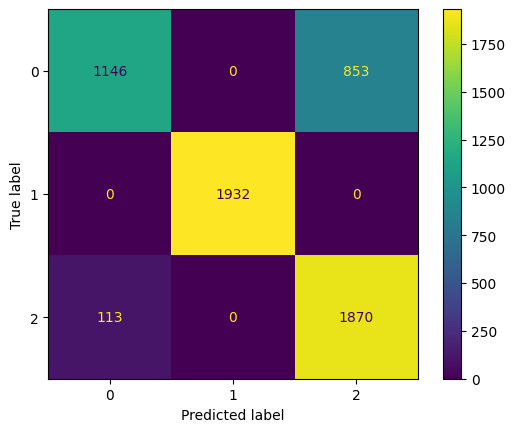

In [32]:
cm = confusion_matrix(df_pred['actual'],df_pred['pred'])
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm).plot()


In [33]:
print(classification_report(df_pred['actual'],df_pred['pred']))

              precision    recall  f1-score   support

          no       0.91      0.57      0.70      1999
    not sure       1.00      1.00      1.00      1932
         yes       0.69      0.94      0.79      1983

    accuracy                           0.84      5914
   macro avg       0.87      0.84      0.83      5914
weighted avg       0.86      0.84      0.83      5914



In [36]:
print(accuracy_score(df_pred['actual'],df_pred['pred']))

0.8366587757862699


####  "No" has higher precision and lower recall
#### "Yes " has lower precision and higher recall

This can be solved by playing around with threshold but this is a multiclass classification problem the sklearn NaiveBayes uses OvR strategy. We have to adjust the threshold for each binary classifier separately.

Also adjusting the threshold for one binary classifier may affect the performance of others

In [34]:
nb.predict(tfv.transform(["US economy faces serious challenges"]))

array(['yes'], dtype='<U8')

In [35]:
nb.predict(tfv.transform(["Indian economy faces serious challenges"]))

array(['no'], dtype='<U8')

In [37]:
df_pred_nos = df_pred.applymap(lambda x:0 if x=='yes' else (1 if x=='no' else 2))

In [38]:
df_pred_nos

,pred,actual
16817,0,0
19251,0,0
12693,2,2
1792,1,1
2136,0,0
...,...,...
14155,2,2
9767,2,2
9800,2,2
944,0,1


In [39]:
from sklearn.metrics import roc_auc_score,precision_score,recall_score

print(precision_score(df_pred['actual'],df_pred['pred'],average=None))

[0.91024623 1.         0.68674256]


## Saving the ML model using pickle

In [42]:
import pickle
pickle.dump(nb,open('model.pkl','wb'))

In [43]:
pickle.dump(tfv,open('tfidf.pkl','wb'))